# R23 - Molecular Dynamics - Dimensionality Reduction

## Introduction

Molecular Dynamics of large molecular systems, as solvated proteins, are usually challenging due to the huge number of degrees of freedom (generally, $3N -3$, where $N$ is the number of atoms). In extreme scenarios, we might work with millions of degrees of freedom. Therefore, how can we extract useful information from such a big amount of data?

Although solvated proteins and other molecular systems are very big and contain many atoms, the motions of these atoms are usually restrained due to different factors: molecular bonds, local stable conformations (e.g. secondary structure), global conformations (e.g. tertiary structure), etc. Therefore, it is possible that a space with lower dimensionality is still able to describe most of the movements that we observe — in other words, particles are correlated, so we don't need to know how each of them moves at all times.

The easiest path for trajectory dimensionality reduction is the linear path: using the principal component analysis on the 3D cartesian coordinates to find a set of orthogonal motions that represent how our particles move. If there are linear patterns in our trajectory, the PCA should be able to recover those as main components with large associated variances . If there are no clear patterns, then the PCA should provide a set of modes with very similar variances.

The PCA is computed from the diagonalization of the covariance matrix. If our trajectory over time generates a matrix A that is [t, 3*N], then we would compute the covariance of this matrix as:

$$ C = \frac{1}{3 * N}AA^{T} $$

The diagonalization of this matrix should provide a matrix P with all the modes, and a list of eigenvalues or variance-associated ratios that show how much does each of these modes represent the overall trajectory.

Luckily for us, we don't need to compute the PCA manually, we can just rely on the usage of either sklearn PCA implementation or in the usage of the essential dynamics module from MDAnalysis.



In [1]:
md_reference_data = None
upstream = None
product = None

In [2]:
# Parameters
md_reference_data = {
    "1bwv": {
        "dry_dcd": "1bwv.exp01.md01.dry.dcd",
        "dry_pdb": "1bwv.exp01.md01.dry.pdb",
        "time": "extant",
    },
    "3zxw": {
        "dry_dcd": "3zxw.exp01.md01.dry.dcd",
        "dry_pdb": "3zxw.exp01.md01.dry.pdb",
        "time": "extant",
    },
    "6ftl": {
        "dry_dcd": "6ftl.exp01.md01.dry.dcd",
        "dry_pdb": "6ftl.exp01.md01.dry.pdb",
        "time": "extant",
    },
    "6ura": {
        "dry_dcd": "6ura.exp01.md01.dry.dcd",
        "dry_pdb": "6ura.exp01.md01.dry.pdb",
        "time": "extant",
    },
    "8ruc": {
        "dry_dcd": "8ruc.exp01.md01.dry.dcd",
        "dry_pdb": "8ruc.exp01.md01.dry.pdb",
        "time": "extant",
    },
    "anci": {
        "dry_dcd": "anci.exp01.md01.dry.dcd",
        "dry_pdb": "anci.exp01.md01.dry.pdb",
        "time": "ancient",
    },
    "anciab": {
        "dry_dcd": "anciab.exp01.md01.dry.dcd",
        "dry_pdb": "anciab.exp01.md01.dry.pdb",
        "time": "ancient",
    },
    "ancicd": {
        "dry_dcd": "ancicd.exp01.md01.dry.dcd",
        "dry_pdb": "ancicd.exp01.md01.dry.pdb",
        "time": "ancient",
    },
    "ancia": {
        "dry_dcd": "ancia.exp01.md01.dry.dcd",
        "dry_pdb": "ancia.exp01.md01.dry.pdb",
        "time": "ancient",
    },
    "ancib": {
        "dry_dcd": "ancib.exp01.md01.dry.dcd",
        "dry_pdb": "ancib.exp01.md01.dry.pdb",
        "time": "ancient",
    },
    "anciip": {
        "dry_dcd": "anciip.exp01.md01.dry.dcd",
        "dry_pdb": "anciip.exp01.md01.dry.pdb",
        "time": "ancient",
    },
    "ancip": {
        "dry_dcd": "ancip.exp01.md01.dry.dcd",
        "dry_pdb": "ancip.exp01.md01.dry.realigned.pdb",
        "time": "ancient",
    },
}
product = {
    "nb": "/mnt/researchdrive/bCuevas/r23/github_repo/RuBisCO_evolution/analysis/output/out-04-R23-md-dimred.ipynb",
    "singles_pca": "/mnt/researchdrive/bCuevas/r23/github_repo/RuBisCO_evolution/analysis/output/singles-pca.json",
    "joint_pca": "/mnt/researchdrive/bCuevas/r23/github_repo/RuBisCO_evolution/analysis/output/joint-pca.json",
    "joint_pca_variance": "/mnt/researchdrive/bCuevas/r23/github_repo/RuBisCO_evolution/analysis/output/joint-pca-variance.csv",
}


## Essential Dynamics - Performing dimensionality reduction through PCA

In [3]:
import json
import prody as pdy
import numpy as np
import scipy as sci
import matplotlib.pyplot as plt
import MDAnalysis as mda
import seaborn as sns
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA as sk_pca
import matplotlib.gridspec as gridspec
from MDAnalysis.analysis import pca as md_pca # We alias the funciton to avoid mistunderstandings
import MDAnalysis.transformations as trans
from MDAnalysis.analysis import align, rms, distances
from mdtools.mapping import map_alignment_to_structure, align_structure_sequences

from Bio import AlignIO

from Bio.SeqUtils import seq1
from Bio.SeqIO import SeqRecord
from Bio import SeqIO
from Bio.Seq import Seq

from tqdm import tqdm

/home/kaustubh/miniconda3/envs/md-analysis/lib/python3.10/site-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


In [4]:
def trajectory_to_pc(trajectory, selection):
    ag = trajectory.select_atoms(selection)
    coordinates = np.stack([ag.positions.reshape(-1) for frame in trajectory.trajectory])
    coordinates = StandardScaler(with_std=False).fit_transform(coordinates)
    sk_pca_object = sk_pca(n_components=10)
    sk_pca_results = sk_pca_object.fit_transform(coordinates)
    return sk_pca_object.explained_variance_ratio_, sk_pca_results

In [5]:
def pca_trajectory(pdb, dcd_list):
    trajectory = mda.Universe(
        pdb, 
        *dcd_list
    )
    ag = trajectory.select_atoms('name CA')
    coordinates = np.stack([ag.positions.reshape(-1) for frame in trajectory.trajectory])
    coordinates = StandardScaler(with_std=False).fit_transform(coordinates)
    sk_pca_object = sk_pca(n_components=10)
    sk_pca_results = sk_pca_object.fit_transform(coordinates)
    return sk_pca_results
    
def get_single_trajectory(trajectory, code, path, include_ssu=True):
    
    start_num_lsu = trajectory.select_atoms('name CA and segid A')[0].resid
    end_num_lsu = trajectory.select_atoms('name CA and segid A')[-1].resid
    if include_ssu:
        try:
            start_num_ssu = trajectory.select_atoms('name CA and segid B')[0].resid
            end_num_ssu = trajectory.select_atoms('name CA and segid B')[-1].resid
        except IndexError:
            include_ssu = False
    else:
        pass
    if include_ssu:
        ag = trajectory.select_atoms(
            'name CA and (segid A or segid E or segid I or segid M or segid C or segid G or segid K or segid O) and resid ' + str(start_num_lsu + 10) + \
            '-' + str(end_num_lsu - 10), 'name CA and (segid B or segid F or segid J or segid N or segid D or segid H or segid L or segid P) and resid ' + \
            str(start_num_ssu + 10) + '-' + str(end_num_ssu - 10))
    else:
        ag = trajectory.select_atoms('name CA and (segid A or segid E or segid I or segid M or segid C or segid G or segid K or segid O) and resid ' + \
            str(start_num_lsu + 10) + '-' + str(end_num_lsu - 10))
    coordinates = np.stack([ag.positions.reshape(-1) for frame in trajectory.trajectory])
    coordinates = StandardScaler(with_std=False).fit_transform(coordinates)
    sk_pca_object = sk_pca(n_components=10)
    sk_pca_results = sk_pca_object.fit_transform(coordinates)
    components = sk_pca_object.components_.copy()
    
    return sk_pca_results, components, sk_pca_object


def load_trajectory(code, data, path):
    
    """
    loads the following files
    - an MDAnalysis trajectory with the dried (water-removed) dcd
    - an MDAnalysis Universe with the starting PDB (jic)
    - an prody with the starting PDB (pretty useful when MDAnalysis fails)
    """
    return dict(
        code=code,
        trajectory_dry = mda.Universe(
            path + data['dry_pdb'], 
            path + data['dry_dcd'], 
            frames='all', in_memory=True
        ),
        reference_pdy=pdy.parsePDB(path + data['dry_pdb']),
        reference=mda.Universe(
            path + data['dry_pdb']
        ),
        time=data['time']
    )

def map_to_protein(code, components, ref):
    component_norm = np.linalg.norm(components.reshape([10, -1, 3]), axis=2)    # The [10, -1, 3] reshapes the components data into a 10 x X x 3 array, where -1 refers to the total number of residues/atoms that exist in the protein
    start_num_lsu = ref.select_atoms('name CA and segid A')[0].resid
    end_num_lsu = ref.select_atoms('name CA and segid A')[-1].resid
    ref.add_TopologyAttr('tempfactors')

    for i, res in enumerate(ref.select_atoms('protein and resid ' + str(start_num_lsu + 10) + '-' + str(end_num_lsu - 10)).residues):
        res.atoms.tempfactors = component_norm[0, i]/(component_norm[0, :].max())

    ref.select_atoms('protein').write(f'./output/{code}.pca-component0.pdb')


## Other Trajectories with single replicates
- 10 residue truncations are implemented at the N & C-terminal

In [6]:
path = '../../../simulations/'
exp01_md = []
for key, items in md_reference_data.items():
    print(f"-- code {key}", end='')
    exp01_md.append(load_trajectory(
        code=key, data=items, path=path
    ))
    print(f" loaded")
exp01_md = pd.DataFrame.from_records(exp01_md).set_index('code')

-- code 1bwv

/home/kaustubh/miniconda3/envs/md-analysis/lib/python3.10/site-packages/MDAnalysis/topology/PDBParser.py:328: UserWarning: Element information is missing, elements attribute will not be populated. If needed these can be guessed using MDAnalysis.topology.guessers.
  warnings.warn("Element information is missing, elements attribute "


@> 77672 atoms and 1 coordinate set(s) were parsed in 3.81s.


 loaded
-- code 3zxw

@> 69984 atoms and 1 coordinate set(s) were parsed in 4.04s.


 loaded
-- code 6ftl

@> 77416 atoms and 1 coordinate set(s) were parsed in 3.64s.


 loaded
-- code 6ura

@> 54648 atoms and 1 coordinate set(s) were parsed in 0.93s.


 loaded
-- code 8ruc

@> 74224 atoms and 1 coordinate set(s) were parsed in 2.29s.


 loaded
-- code anci

@> 72128 atoms and 1 coordinate set(s) were parsed in 5.56s.


 loaded
-- code anciab

@> 72640 atoms and 1 coordinate set(s) were parsed in 2.65s.


 loaded
-- code ancicd

@> 76208 atoms and 1 coordinate set(s) were parsed in 3.88s.


 loaded
-- code ancia

@> 73536 atoms and 1 coordinate set(s) were parsed in 3.24s.


 loaded
-- code ancib

@> 72352 atoms and 1 coordinate set(s) were parsed in 0.92s.


 loaded
-- code anciip

@> 55120 atoms and 1 coordinate set(s) were parsed in 4.80s.


 loaded
-- code ancip

@> 54768 atoms and 1 coordinate set(s) were parsed in 1.43s.


 loaded


In [7]:
pca_out = []
for key, item in exp01_md.iterrows():

    lsussu_pca, lsussu_components, lsussu_pca_object = get_single_trajectory(item['trajectory_dry'], key, '../simulations/', include_ssu=True)
    lsu_pca, lsu_components, lsu_pca_object = get_single_trajectory(item['trajectory_dry'], key, '../simulations/', include_ssu=False)
    pca_out.append(dict(
        code=key, 
        lsussu_pca=lsussu_pca, lsussu_variance_ratio=lsussu_pca_object.explained_variance_ratio_,
        lsu_pca=lsu_pca, lsu_variance_ratio=lsu_pca_object.explained_variance_ratio_,
    ))
    # map_to_protein(key, lsussu_components, item['trajectory_dry'])

pca_out = pd.DataFrame.from_records(pca_out)

### PCA-plots for the motions of LSU-only

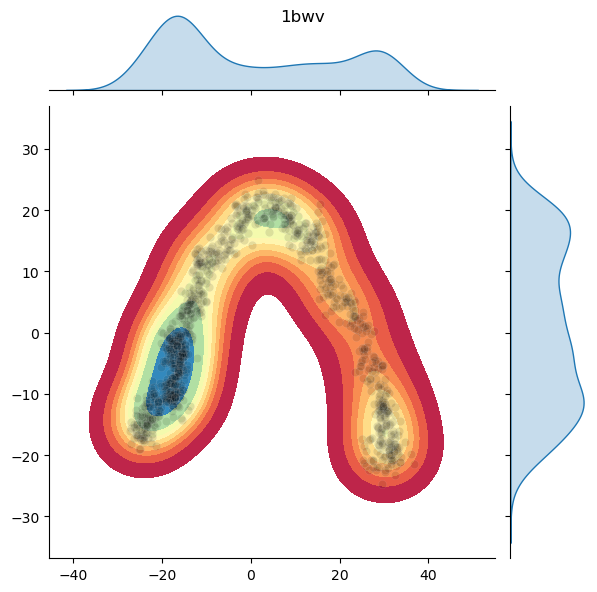

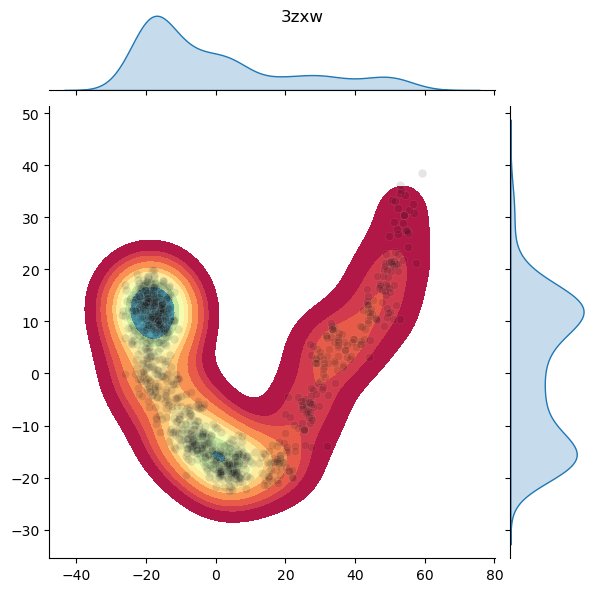

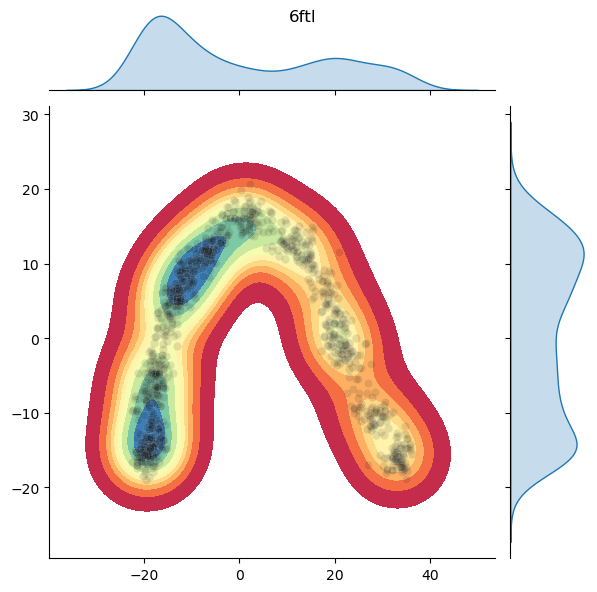

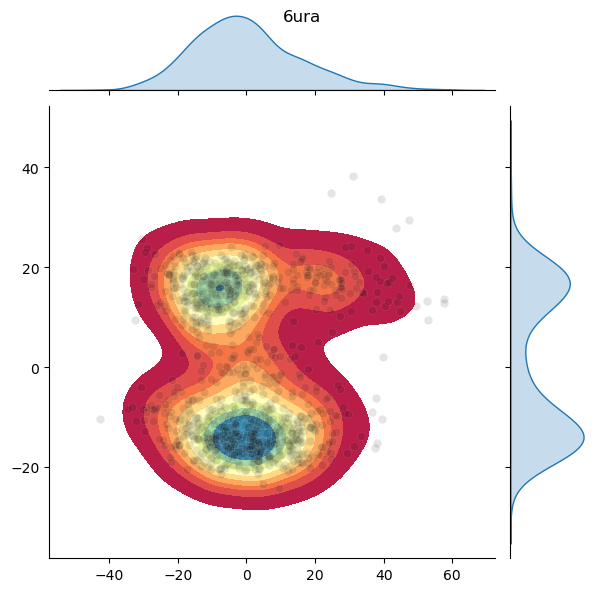

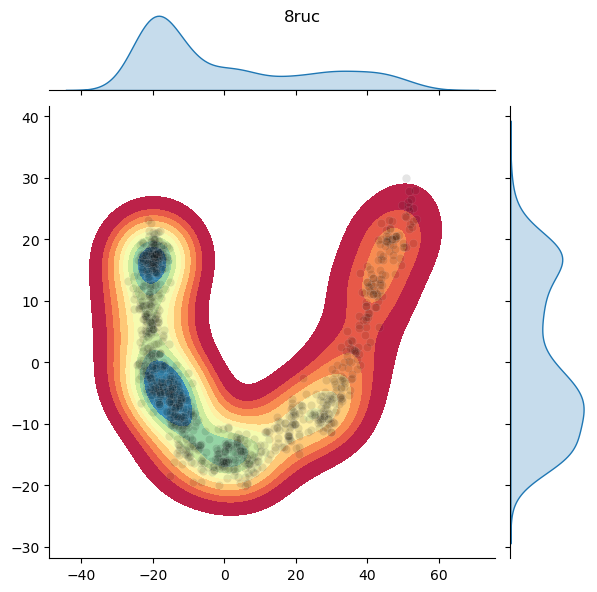

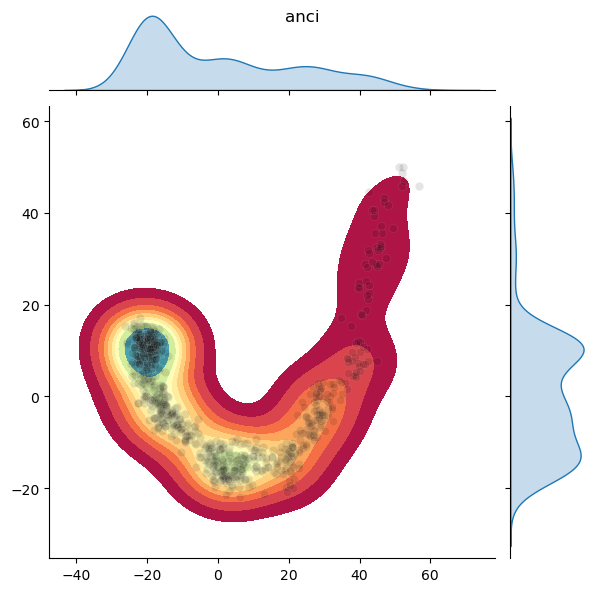

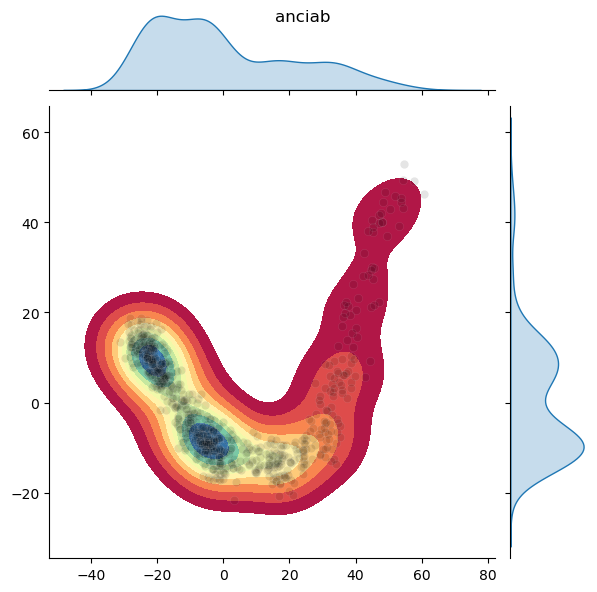

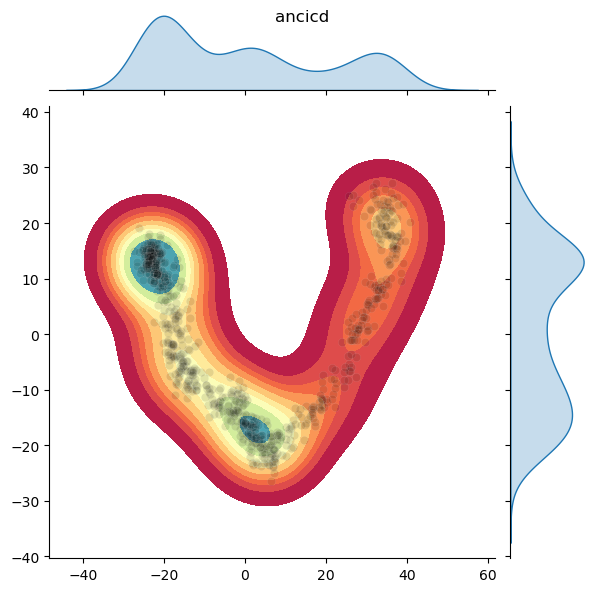

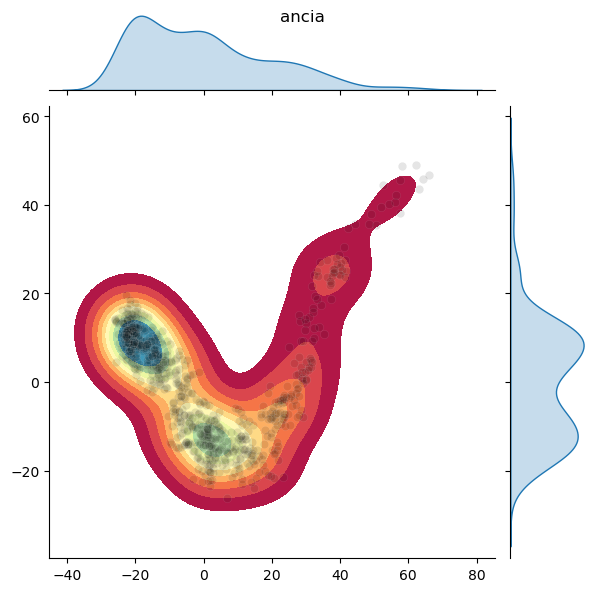

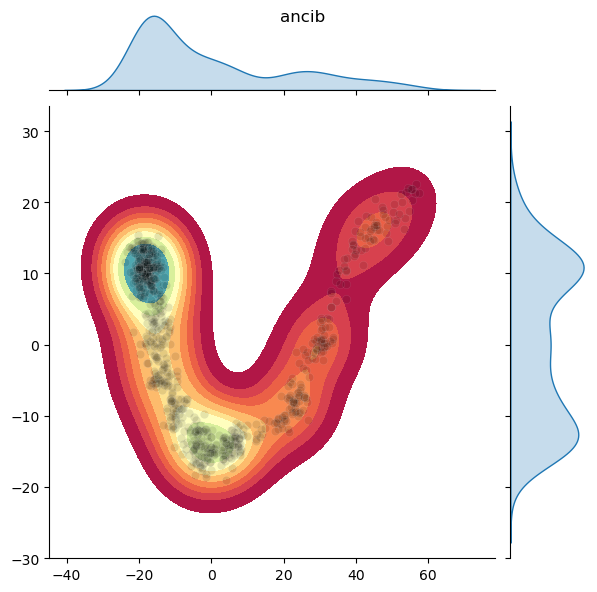

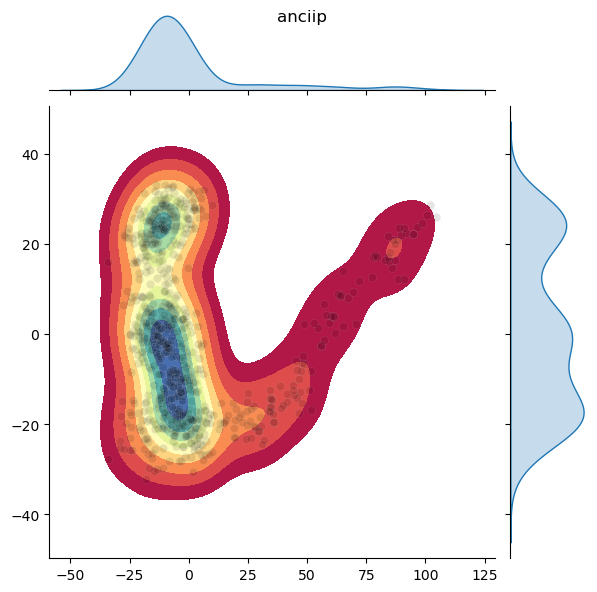

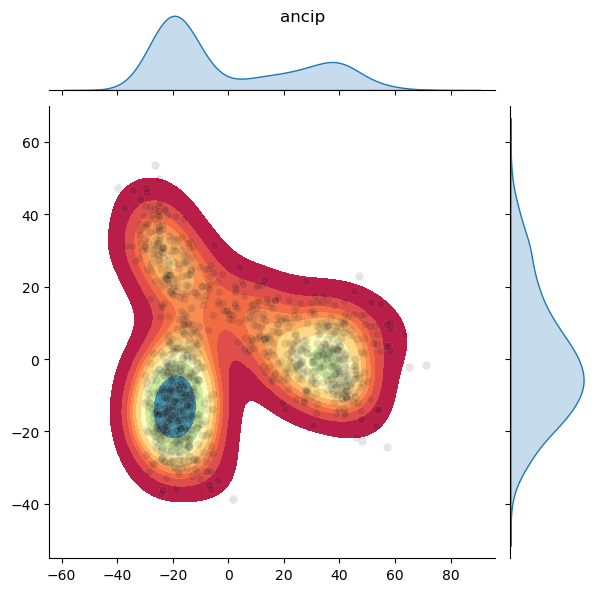

In [8]:
for index, items in pca_out.iterrows():
    pca = np.array(items['lsu_pca'])
    g = sns.jointplot(x=pca[:, 0], y=pca[:, 1], kind='kde', joint_kws={"fill":True}, cmap='Spectral')
    g.plot_joint(sns.scatterplot, color="black", alpha=0.1)
    g.fig.suptitle(items['code'])

### Plotting the explained variance ratio with each PC

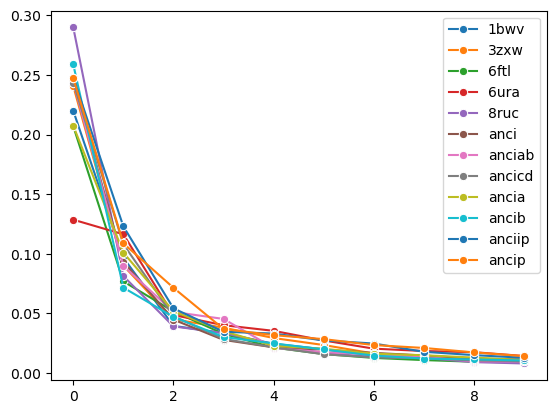

In [9]:
for index, items in pca_out.iterrows():
    sns.lineplot(x=np.arange(len(items['lsu_variance_ratio'])), y=np.array(items['lsu_variance_ratio']), marker='o', label=items['code'])

### PCA-plots for the motions of both LSU and SSU

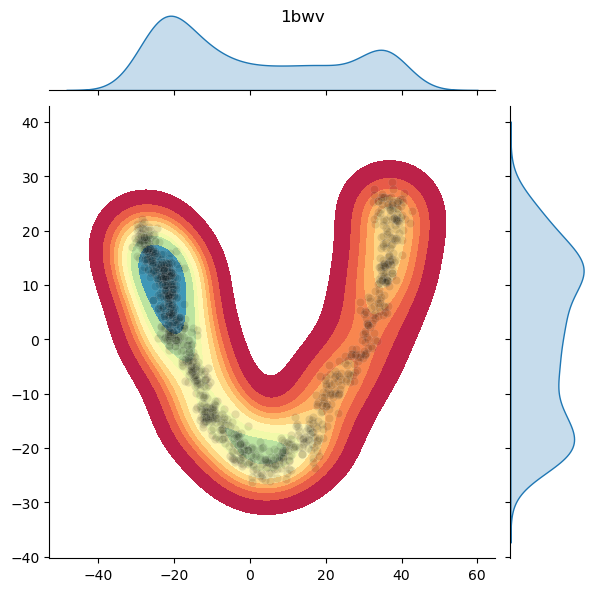

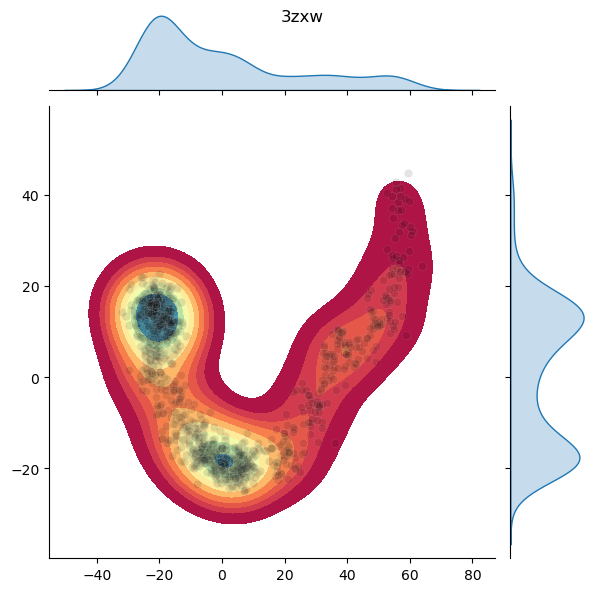

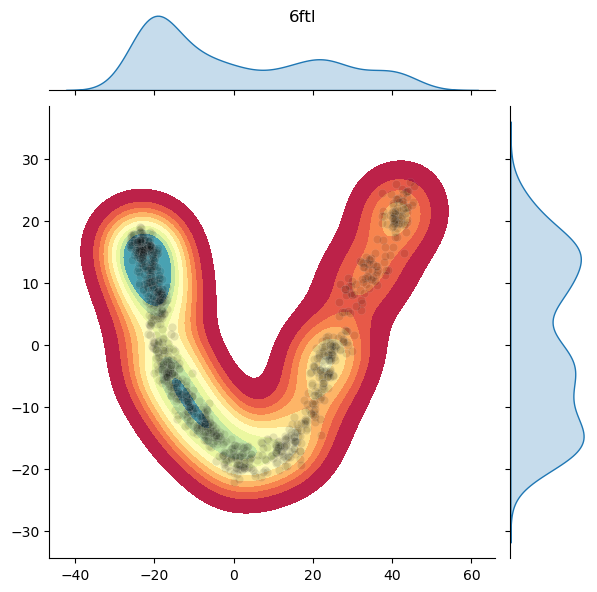

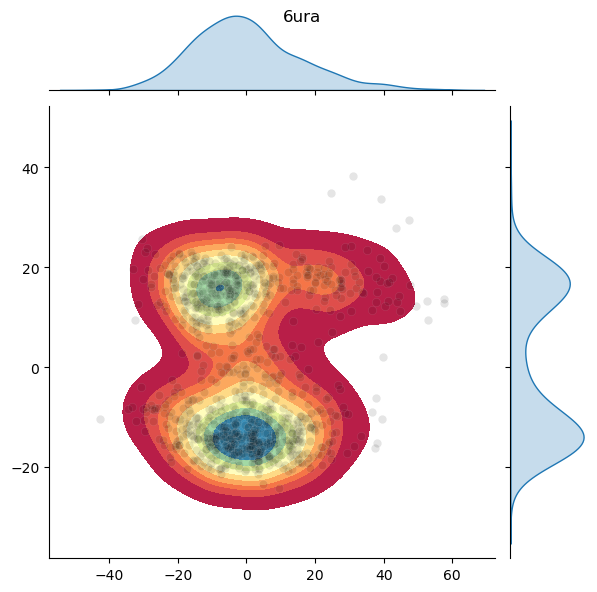

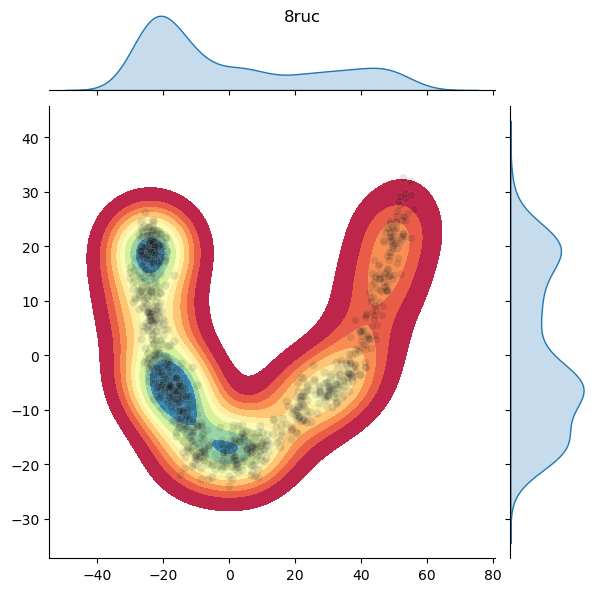

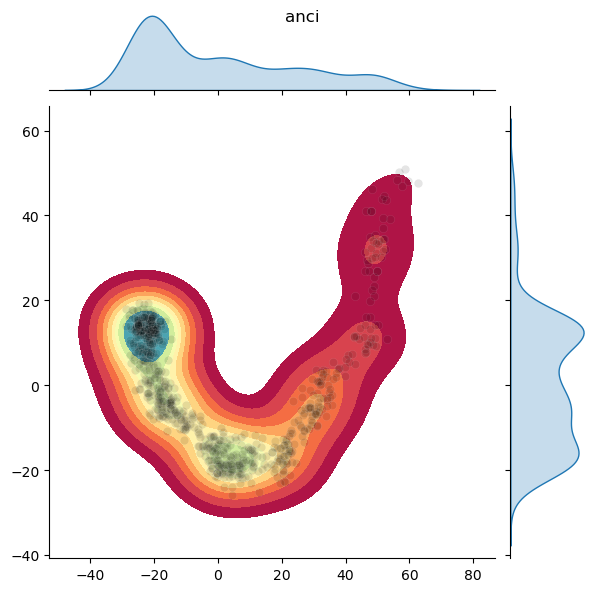

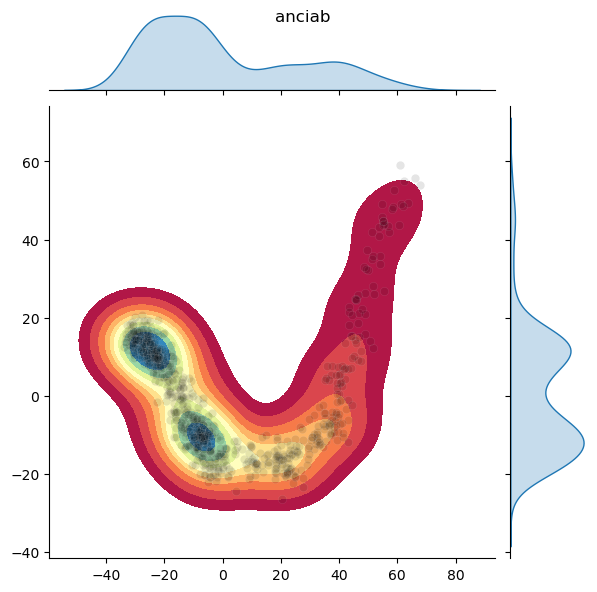

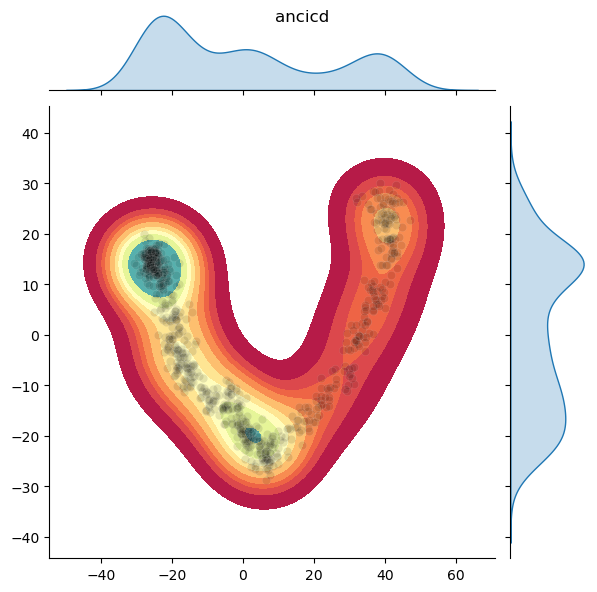

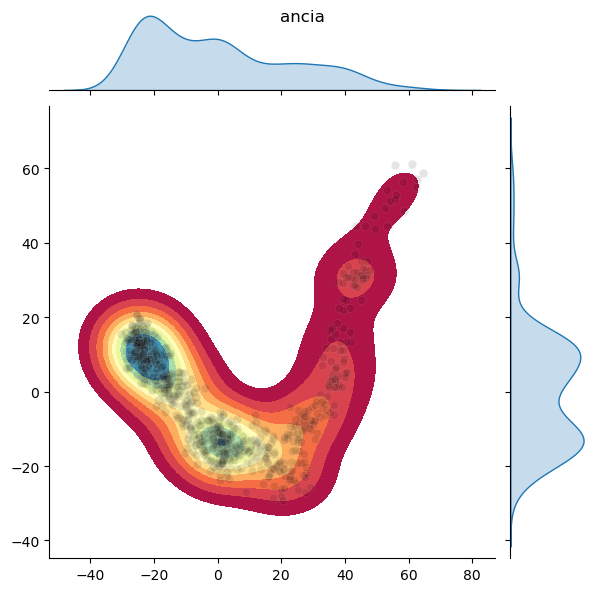

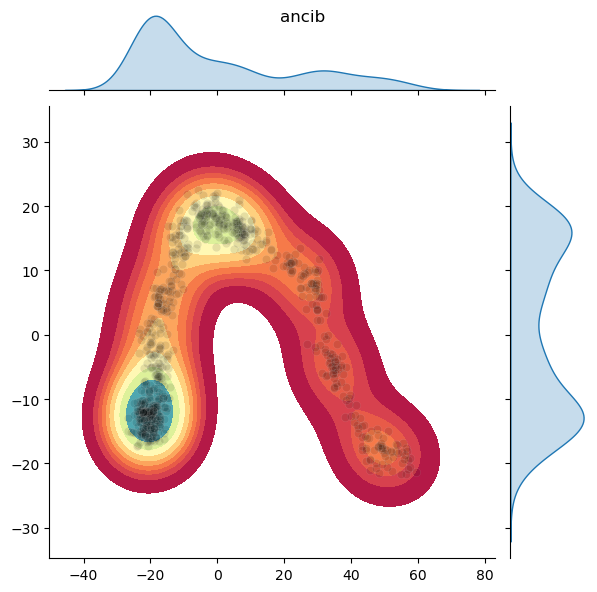

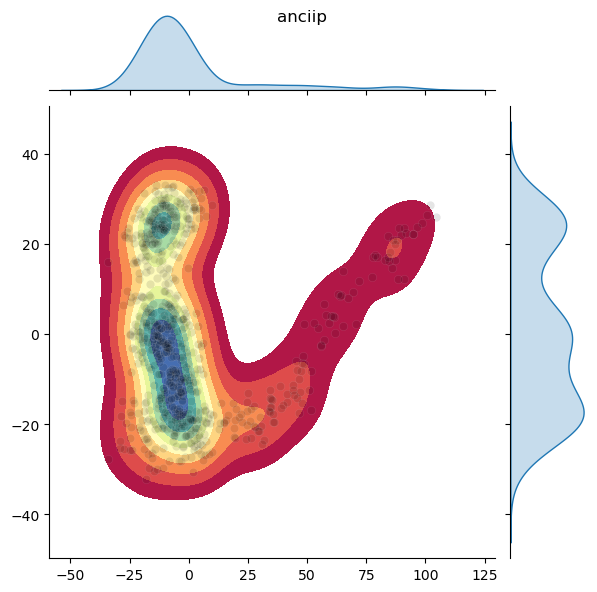

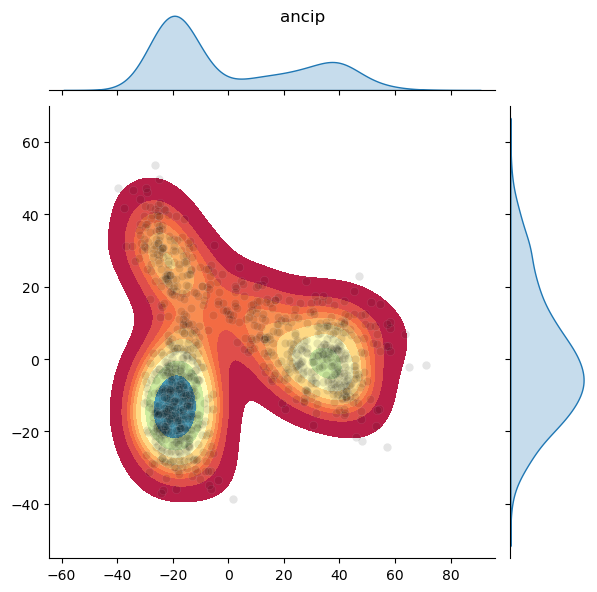

In [10]:
for index, items in pca_out.iterrows():
    pca = np.array(items['lsussu_pca'])
    g = sns.jointplot(x=pca[:, 0], y=pca[:, 1], kind='kde', joint_kws={"fill":True}, cmap='Spectral')
    g.plot_joint(sns.scatterplot, color="black", alpha=0.1)
    g.fig.suptitle(items['code'])

In [11]:
pca_out.to_json(product['singles_pca'], orient='records')

### 5 independent replicates of the PCA-plots

In [12]:
# md05_ref_data = json.load(open('./md_simulations_early_branch_rep5.json', 'r'))

# path = '../../../simulations/'
# rep_5_md = []
# for key, items in md05_ref_data.items():
#     print(f"-- code {key}", end='')
#     rep_5_md.append(load_trajectory(
#         code=key, data=items, path=path
#     ))
#     print(f" loaded")
# rep_5_md = pd.DataFrame.from_records(rep_5_md).set_index('code')

In [13]:
# rep5_pca_out = []
# for key, item in rep_5_md.iterrows():
#     lsu_pca, lsu_components, lsu_pca_object = get_single_trajectory(item['trajectory_dry'], key, '../simulations/', include_ssu=False)
#     rep5_pca_out.append(dict(
#         code=key, 
#         lsu_pca=lsu_pca, lsu_variance_ratio=lsu_pca_object.explained_variance_ratio_,
#     ))

# rep5_pca_out = pd.DataFrame.from_records(rep5_pca_out)

In [14]:
# for index, items in rep5_pca_out.iterrows():
#     pca = np.array(items['lsu_pca'])
#     g = sns.jointplot(x=pca[:, 0], y=pca[:, 1], kind='kde', joint_kws={"fill":True}, cmap='Spectral')
#     g.plot_joint(sns.scatterplot, color="black", alpha=0.1)
#     g.fig.suptitle(items['code'])

## Essential Collective Dynamics

In [15]:
def load_trajectory(code, data, path):
    return dict(
        code=code,
        trajectory_dry = mda.Universe(
            path + data['dry_pdb'], 
            path + data['dry_dcd'], 
            frames='all'
        ),
        reference_pdy=pdy.parsePDB(path + data['dry_pdb']),
        reference=mda.Universe(
            path + data['dry_pdb'], in_memory=True
        ),
        time=data['time']
    )

In [16]:
def residues2sequence(residues):
    out = ""
    for res in residues:
        resname = res.resname.replace('KCX', 'LYS')

        out += seq1(resname)
    return out

def get_sequences(ref, chains):
    sequence_bag = []
    for chain in chains:
        sequence_bag.append(
            (  
                chain,
                residues2sequence(ref.select_atoms(f'protein and chainID {chain}').residues)
            )
            
        )
    return sequence_bag

In [17]:
path = '../../../simulations/'
md_reference_data = json.load(open('./md_simulations.json', 'r'))
exp01_md = []
for key, items in md_reference_data.items():
    print(f"-- code {key}", end='')
    exp01_md.append(load_trajectory(
        code=key, data=items, path=path
    ))
    print(f" loaded")
exp01_md = pd.DataFrame.from_records(exp01_md).set_index('code')
a = align.AlignTraj(exp01_md.loc['ancip'].trajectory_dry, exp01_md.loc['ancip'].reference, in_memory=True, select='name CA')
a.run()

-- code 1bwv

/home/kaustubh/miniconda3/envs/md-analysis/lib/python3.10/site-packages/MDAnalysis/topology/PDBParser.py:328: UserWarning: Element information is missing, elements attribute will not be populated. If needed these can be guessed using MDAnalysis.topology.guessers.
  warnings.warn("Element information is missing, elements attribute "


@> 77672 atoms and 1 coordinate set(s) were parsed in 0.37s.


/home/kaustubh/miniconda3/envs/md-analysis/lib/python3.10/site-packages/MDAnalysis/core/universe.py:641: UserWarning: Reader has no dt information, set to 1.0 ps
  dt=self.trajectory.ts.dt * step,


 loaded
-- code 3zxw

@> 69984 atoms and 1 coordinate set(s) were parsed in 0.32s.


 loaded
-- code 6ftl

@> 77416 atoms and 1 coordinate set(s) were parsed in 0.36s.


 loaded
-- code 6ura

@> 54648 atoms and 1 coordinate set(s) were parsed in 0.26s.


 loaded
-- code 8ruc

@> 74224 atoms and 1 coordinate set(s) were parsed in 0.36s.


 loaded
-- code anci

@> 72128 atoms and 1 coordinate set(s) were parsed in 0.34s.


 loaded
-- code anciab

@> 72640 atoms and 1 coordinate set(s) were parsed in 0.34s.


 loaded
-- code ancicd

@> 76208 atoms and 1 coordinate set(s) were parsed in 0.36s.


 loaded
-- code ancia

@> 73536 atoms and 1 coordinate set(s) were parsed in 0.34s.


 loaded
-- code ancib

@> 72352 atoms and 1 coordinate set(s) were parsed in 0.34s.


 loaded
-- code anciip

@> 55120 atoms and 1 coordinate set(s) were parsed in 0.26s.


 loaded
-- code ancip

@> 54768 atoms and 1 coordinate set(s) were parsed in 0.23s.


 loaded


In [18]:
exp01_md['rbcl_seq'] = exp01_md['reference'].apply(lambda x: get_sequences(x, chains='ACEGIKMO'))
exp01_md['rbcl_seq']

code
1bwv      [(A, RIKNSRYESGVIPYAKMGYWNPDYQVKDTDVLALFRVTPQP...
3zxw      [(A, GYQAGVKDYRLTYYTPDYTPKDTDILAAFRVTPQPGVPFEE...
6ftl      [(A, QSVSERTRIKSDRYESGVIPYAKMGYWDASYTVKDTDVLAL...
6ura      [(A, DAYKAGVRAYAVDYYVPDYIPQDTDLLCAFRIQPRGVDMIE...
8ruc      [(A, ASVEFKAGVKDYKLTYYTPEYETLDTDILAAFRVSPQPGVP...
anci      [(A, AQFQAGVREYRETYYDPGYTPKDTDILAAFRVTPQPGVPPE...
anciab    [(A, AMYQAGVKDYRETYYDPDYTPKDTDILAAFRVTPQPGVPPE...
ancicd    [(A, SEEEKERLSAGVRPYAEMGYWDPDYEPKDTDILAAFRITPQ...
ancia     [(A, AKTYQAGVKDYRETYWDPDYTPKDTDILACFKITPQPGVPR...
ancib     [(A, KAGYQAGVKDYRLTYYTPDYTPKDTDILAAFRVTPQPGVPP...
anciip    [(A, PQFQAGVRPYRETYYDPGYTPRDTDILCAFRIQPKPGVDLE...
ancip     [(A, PQFQAGVRPYRETYYDPDYTPRETDILCAFRIQPKPGVDLV...
Name: rbcl_seq, dtype: object

In [19]:
seq_list = []
for key, item in exp01_md['rbcl_seq'].items():
    for chain, seq in item:
        seq_list.append(SeqRecord(seq=Seq(seq), id='{:s}_{:s}'.format(key, chain)))
SeqIO.write(seq_list, './output/sequence.fasta', 'fasta')

96

In [20]:
!mafft --maxiterate 1000 --localpair './output/sequence.fasta' > './output/sequence.aligned.fasta'

outputhat23=16
treein = 0
compacttree = 0
stacksize: 8192 kb
rescale = 1
All-to-all alignment.


tbfast-pair (aa) Version 7.505
alg=L, model=BLOSUM62, 2.00, -0.10, +0.10, noshift, amax=0.0
0 thread(s)

outputhat23=16
Loading 'hat3.seed' ... 
done.
Writing hat3 for iterative refinement
rescale = 1
Gap Penalty = -1.53, +0.00, +0.00
tbutree = 1, compacttree = 0
Constructing a UPGMA tree ... 
   90 / 96
done.

Progressive alignment ... 
STEP    10 /95 

STEP    44 /95 

STEP    77 /95 

STEP    95 /95 
done.
tbfast (aa) Version 7.505
alg=A, model=BLOSUM62, 1.53, -0.00, -0.00, noshift, amax=0.0
1 thread(s)

minimumweight = 0.000010
autosubalignment = 0.000000
nthread = 0
randomseed = 0
blosum 62 / kimura 200
poffset = 0
niter = 16
sueff_global = 0.100000
nadd = 16
Loading 'hat3' ... done.
rescale = 1

   90 / 96
Segment   1/  1    1- 483
STEP 001-001-0 

STEP 001-018-0 

STEP 001-035-0 

STEP 001-053-1 

STEP 001-071-1 

STEP 001-087-1 

STEP 001-094-0 

STEP 002-090-0 

STEP 002-079-0 

STEP 002-061-1 

STEP 002-042-0 

STEP 002-024-0 

STEP 002-007-0 


Converged.

done
dvtditr (aa) Version 7.505
alg=A, model=BLOSUM62, 1.53, -0.00, -0.00, noshift, amax=0.0
0 thread(s)


Strategy:
 L-INS-i (Probably most accurate, very slow)
 Iterative refinement method (<16) with LOCAL pairwise alignment information

If unsure which option to use, try 'mafft --auto input > output'.
For more information, see 'mafft --help', 'mafft --man' and the mafft page.

The default gap scoring scheme has been changed in version 7.110 (2013 Oct).
It tends to insert more gaps into gap-rich regions than previous versions.
To disable this change, add the --leavegappyregion option.



In [21]:
aligned_sequences = list(pdy.MSAFile(
    './output/sequence.aligned.fasta', format='fasta') # TODO Fix this
)

aligment_matrix = np.stack([item.getArray() for item in aligned_sequences])
conserved_positions = []
for i in range(aligment_matrix.shape[1]):
    if b'-' not in np.unique(aligment_matrix[:, i]).tolist():
        conserved_positions.append(i)

In [22]:
def remove_gaps(sequence):
    for i, tokken in enumerate(sequence):
        if tokken != '-':
            yield i, tokken

def conserved2bfactor(sequence, conserved, chain, structure):
    # structure.add_TopologyAttr('tempfactors')
    residues = structure.select_atoms(f'protein and chainID {chain}').residues
    for (i, tokken), res in zip(remove_gaps(sequence), residues):
        
        if tokken != seq1(res.resname) and res.resname != "HIE":
            # print(res.resnum, tokken, seq1(res.resname))
            pass
        if i in conserved:
            try:
                print(res.resnum, tokken, seq1(res.resname))
                res.atoms.tempfactors = 1.0
            except AttributeError:
                print(f"{i} {tokken} {res.resname}")
        else:
            res.atoms.tempfactors = 0.0

In [23]:
for seq in aligned_sequences:
    key = seq.getLabel()
    protein = key.split()[0].split('_')[0]
    chain = key.split()[0].split('_')[1]
    item = exp01_md.loc[protein]
    print(protein, chain)
    conserved2bfactor(
        str(seq), conserved_positions, chain, item.trajectory_dry
    )

1bwv A
12 R R
13 Y Y
14 E E
15 S S
16 G G
17 V V
18 I I
19 P P
20 Y Y
21 A A
22 K K
23 M M
25 Y Y
26 W W
27 N N
28 P P
29 D D
30 Y Y
31 Q Q
32 V V
33 K K
34 D D
35 T T
36 D D
37 V V
38 L L
39 A A
40 L L
41 F F
42 R R
43 V V
44 T T
45 P P
46 Q Q
48 G G
49 V V
50 D D
51 P P
52 I I
53 E E
54 A A
55 A A
56 A A
57 A A
58 V V
59 A A
60 G G
61 E E
62 S S
63 S S
64 T T
65 A A
66 T T
67 W W
68 T T
69 V V
70 V V
71 W W
72 T T
73 D D
74 L L
75 L L
76 T T
77 A A
78 A A
79 D D
80 L L
81 Y Y
82 R R
83 A A
84 K K
85 A A
86 Y Y
87 K K
88 V V
89 D D
97 Q Q
98 Y Y
99 F F
100 A A
101 Y Y
102 I I
103 A A
104 Y Y
105 E E
106 L L
107 D D
108 L L
109 F F
110 E E
111 E E
112 G G
113 S S
114 I I
115 A A
116 N N
117 L L
118 T T
119 A A
120 S S
121 I I
122 I I
123 G G
124 N N
125 V V
126 F F
127 G G
128 F F
129 K K
130 A A
131 V V
132 K K
133 A A
134 L L
135 R R
136 L L
137 E E
138 D D
139 M M
140 R R
141 L L
142 P P
143 L L
144 A A
145 Y Y
146 L L
148 T T
149 F F
150 Q Q
151 G G
152 P P
153 A A
154 T T
155 G G


12 G G
13 Y Y
14 Q Q
15 A A
16 G G
17 V V
18 K K
19 D D
20 Y Y
21 R R
22 L L
23 T T
24 Y Y
25 Y Y
26 T T
27 P P
28 D D
29 Y Y
30 T T
31 P P
32 K K
33 D D
34 T T
35 D D
36 I I
37 L L
38 A A
39 A A
40 F F
41 R R
42 V V
43 T T
44 P P
45 Q Q
47 G G
48 V V
49 P P
50 F F
51 E E
52 E E
53 A A
54 A A
55 A A
56 A A
57 V V
58 A A
59 A A
60 E E
61 S S
62 S S
63 T T
64 G G
65 T T
66 W W
67 T T
68 T T
69 V V
70 W W
71 T T
72 D D
73 L L
74 L L
75 T T
76 D D
77 L L
78 D D
79 R R
80 Y Y
81 K K
82 G G
83 C C
84 C C
85 Y Y
86 D D
87 I I
88 E E
96 Q Q
97 F F
98 I I
99 A A
100 Y Y
101 I I
102 A A
103 Y Y
104 P P
105 L L
106 D D
107 L L
108 F F
109 E E
110 E E
111 G G
112 S S
113 V V
114 T T
115 N N
116 M M
117 L L
118 T T
119 S S
120 I I
121 V V
122 G G
123 N N
124 V V
125 F F
126 G G
127 F F
128 K K
129 A A
130 L L
131 K K
132 A A
133 L L
134 R R
135 L L
136 E E
137 D D
138 L L
139 R R
140 I I
141 P P
142 V V
143 A A
144 Y Y
145 L L
147 T T
148 F F
149 Q Q
150 G G
151 P P
152 P P
153 X X
154 G G
155 I I


12 E E
13 F F
14 K K
15 A A
16 G G
17 V V
18 K K
19 D D
20 Y Y
21 K K
22 L L
23 T T
24 Y Y
25 Y Y
26 T T
27 P P
28 E E
29 Y Y
30 E E
31 T T
32 L L
33 D D
34 T T
35 D D
36 I I
37 L L
38 A A
39 A A
40 F F
41 R R
42 V V
43 S S
44 P P
45 Q Q
47 G G
48 V V
49 P P
50 P P
51 E E
52 E E
53 A A
54 G G
55 A A
56 A A
57 V V
58 A A
59 A A
60 E E
61 S S
62 S S
63 T T
64 G G
65 T T
66 W W
67 T T
68 T T
69 V V
70 W W
71 T T
72 D D
73 G G
74 L L
75 T T
76 N N
77 L L
78 D D
79 R R
80 Y Y
81 K K
82 G G
83 R R
84 C C
85 Y Y
86 X X
87 I I
88 E E
96 Q Q
97 Y Y
98 I I
99 C C
100 Y Y
101 V V
102 A A
103 Y Y
104 P P
105 L L
106 D D
107 L L
108 F F
109 E E
110 E E
111 G G
112 S S
113 V V
114 T T
115 N N
116 M M
117 F F
118 T T
119 S S
120 I I
121 V V
122 G G
123 N N
124 V V
125 F F
126 G G
127 F F
128 K K
129 A A
130 L L
131 R R
132 A A
133 L L
134 R R
135 L L
136 E E
137 D D
138 L L
139 R R
140 I I
141 P P
142 V V
143 A A
144 Y Y
145 V V
147 T T
148 F F
149 Q Q
150 G G
151 P P
152 P P
153 X X
154 G G
155 I I


10 M M
11 Y Y
12 Q Q
13 A A
14 G G
15 V V
16 K K
17 D D
18 Y Y
19 R R
20 E E
21 T T
22 Y Y
23 Y Y
24 D D
25 P P
26 D D
27 Y Y
28 T T
29 P P
30 K K
31 D D
32 T T
33 D D
34 I I
35 L L
36 A A
37 A A
38 F F
39 R R
40 V V
41 T T
42 P P
43 Q Q
45 G G
46 V V
47 P P
48 P P
49 E E
50 E E
51 A A
52 A A
53 A A
54 A A
55 V V
56 A A
57 A A
58 E E
59 S S
60 S S
61 T T
62 G G
63 T T
64 W W
65 T T
66 T T
67 V V
68 W W
69 T T
70 D D
71 L L
72 L L
73 T T
74 D D
75 L L
76 D D
77 R R
78 Y Y
79 K K
80 G G
81 R R
82 C C
83 Y Y
84 R R
85 I I
86 E E
94 Q Q
95 Y Y
96 I I
97 A A
98 Y Y
99 V V
100 A A
101 Y Y
102 P P
103 L L
104 D D
105 L L
106 F F
107 E E
108 E E
109 G G
110 S S
111 V V
112 V V
113 N N
114 L L
115 L L
116 T T
117 S S
118 I I
119 V V
120 G G
121 N N
122 V V
123 F F
124 G G
125 F F
126 K K
127 A A
128 L L
129 R R
130 A A
131 L L
132 R R
133 L L
134 E E
135 D D
136 L L
137 R R
138 I I
139 P P
140 V V
141 A A
142 Y Y
143 V V
145 T T
146 F F
147 Q Q
148 G G
149 P P
150 P P
151 X X
152 G G
153 I I
15

5 T T
6 Y Y
7 Q Q
8 A A
9 G G
10 V V
11 K K
12 D D
13 Y Y
14 R R
15 E E
16 T T
17 Y Y
18 W W
19 D D
20 P P
21 D D
22 Y Y
23 T T
24 P P
25 K K
26 D D
27 T T
28 D D
29 I I
30 L L
31 A A
32 C C
33 F F
34 K K
35 I I
36 T T
37 P P
38 Q Q
40 G G
41 V V
42 P P
43 R R
44 E E
45 E E
46 A A
47 A A
48 A A
49 A A
50 V V
51 A A
52 A A
53 E E
54 S S
55 S S
56 T T
57 G G
58 T T
59 W W
60 T T
61 T T
62 V V
63 W W
64 T T
65 D D
66 L L
67 L L
68 T T
69 D D
70 L L
71 D D
72 Y Y
73 Y Y
74 K K
75 G G
76 R R
77 A A
78 Y Y
79 R R
80 I I
81 E E
89 C C
90 F F
91 Y Y
92 A A
93 F F
94 V V
95 A A
96 Y Y
97 P P
98 I I
99 D D
100 L L
101 F F
102 E E
103 E E
104 G G
105 S S
106 V V
107 V V
108 N N
109 V V
110 L L
111 T T
112 S S
113 L L
114 V V
115 G G
116 N N
117 V V
118 F F
119 G G
120 F F
121 K K
122 A A
123 I I
124 R R
125 A A
126 L L
127 R R
128 L L
129 E E
130 D D
131 V V
132 R R
133 F F
134 P P
135 L L
136 A A
137 Y Y
138 V V
140 T T
141 C C
142 G G
143 G G
144 P P
145 P P
146 N N
147 G G
148 I I
149 Q Q
150 

16 Q Q
17 F F
18 Q Q
19 A A
20 G G
21 V V
22 R R
23 P P
24 Y Y
25 R R
26 E E
27 T T
28 Y Y
29 Y Y
30 D D
31 P P
32 G G
33 Y Y
34 T T
35 P P
36 R R
37 D D
38 T T
39 D D
40 I I
41 L L
42 C C
43 A A
44 F F
45 R R
46 I I
47 Q Q
48 P P
49 K K
51 G G
52 V V
53 D D
54 L L
55 E E
56 E E
57 A A
58 A A
59 A A
60 A A
61 V V
62 A A
63 A A
64 E E
65 S S
66 S S
67 T T
68 G G
69 T T
70 W W
71 T T
72 E E
73 V V
74 W W
75 T T
76 N N
77 A A
78 L L
79 T T
80 D D
81 L L
82 E E
83 R R
84 Y Y
85 K K
86 A A
87 R R
88 C C
89 Y Y
90 R R
91 I I
92 E E
93 G G
94 D D
95 I I
96 A A
97 Y Y
98 I I
99 A A
100 Y Y
101 P P
102 L L
103 D D
104 L L
105 F F
106 E E
107 E E
108 G G
109 S S
110 I I
111 V V
112 N N
113 I I
114 M M
115 S S
116 S S
117 I I
118 V V
119 G G
120 N N
121 V V
122 F F
123 G G
124 F F
125 K K
126 A A
127 V V
128 R R
129 A A
130 L L
131 R R
132 L L
133 E E
134 D D
135 M M
136 R R
137 I I
138 P P
139 V V
140 A A
141 L L
142 V V
144 T T
145 F F
146 Q Q
147 G G
148 P P
149 P P
150 X X
151 G G
152 I I
153

In [24]:
positions_buffer = []
label_buffer = []
frame_buffer = []
scaler = StandardScaler(with_std=False)

for key, item in exp01_md.iterrows():
    protein_positions_buffer = []
    for i, frame in enumerate(item.trajectory_dry.trajectory):
        tmp_positions = []
        for chain in 'ACEIGKMO':
            g = item.trajectory_dry.select_atoms(f'protein and prop tempfactor > 0.0 and name CA and chainID {chain}')
            positions = g.positions
            tmp_positions.append(positions)
            
        tmp_positions = np.stack(tmp_positions).reshape(-1)
        protein_positions_buffer.append(tmp_positions)
        label_buffer.append(key)
        frame_buffer.append(i)
    
    # protein_positions_buffer = scaler.fit_transform(np.stack(protein_positions_buffer))
    positions_buffer.append(np.stack(protein_positions_buffer))

positions_buffer = np.concatenate(positions_buffer)
# label_buffer = label_buffer
frame_buffer = np.array(frame_buffer)

In [25]:
positions_buffer.shape

(10500, 10368)

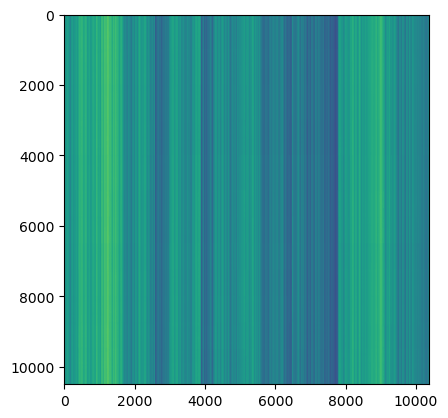

In [26]:
plt.imshow(positions_buffer)

In [27]:
pca = sk_pca(n_components=10, whiten=False)
scaler = StandardScaler(with_mean=True, with_std=False)

X = scaler.fit_transform(positions_buffer)
X = pca.fit_transform(X)

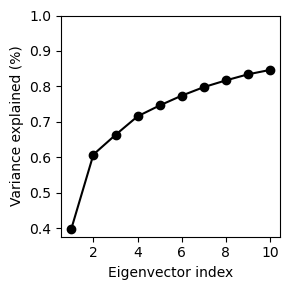

In [28]:
fig, ax = plt.subplots(1)
fig.set_size_inches(3, 3)
ax.plot(np.arange(1, 11), pca.explained_variance_ratio_.cumsum(), marker='o', color='black')
ax.set_xlabel('Eigenvector index')
ax.set_ylabel('Variance explained (%)')
ax.set_ylim(None, 1.0)
fig.tight_layout()

In [29]:
np.savetxt(
    product['joint_pca_variance'],
    pca.explained_variance_ratio_.cumsum()
)

In [30]:
md_pca = pd.DataFrame.from_dict(dict(pca_x=X[:,0], pca_y=X[:, 1], pca_z=X[:, 2], time=frame_buffer, label=label_buffer))
md_pca.to_json(product['joint_pca'])

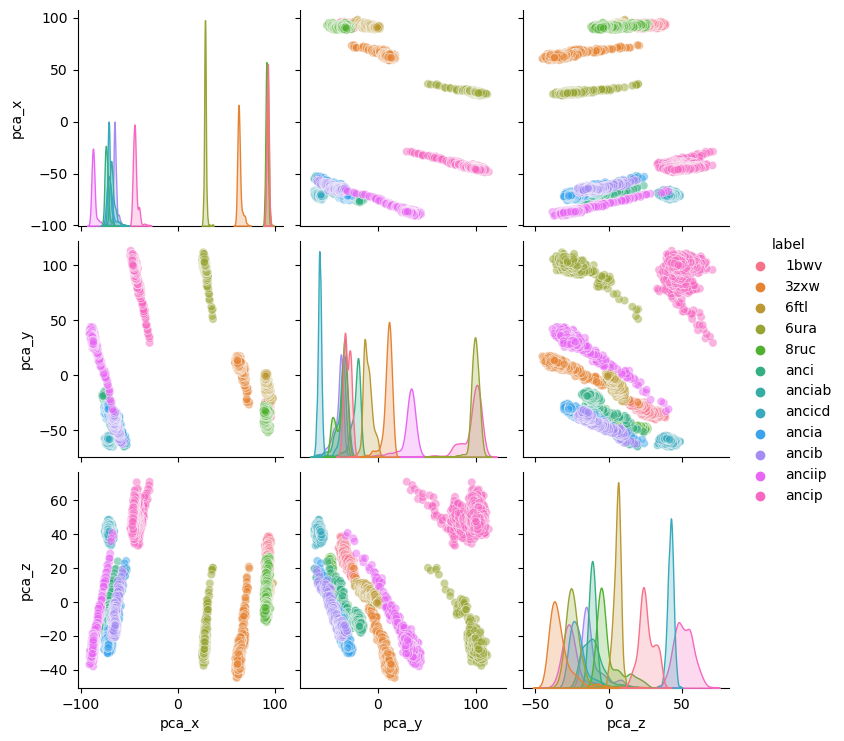

In [31]:
g = sns.pairplot(md_pca[['pca_x', 'pca_y', 'pca_z', 'label']], hue='label', plot_kws={"alpha":0.5})

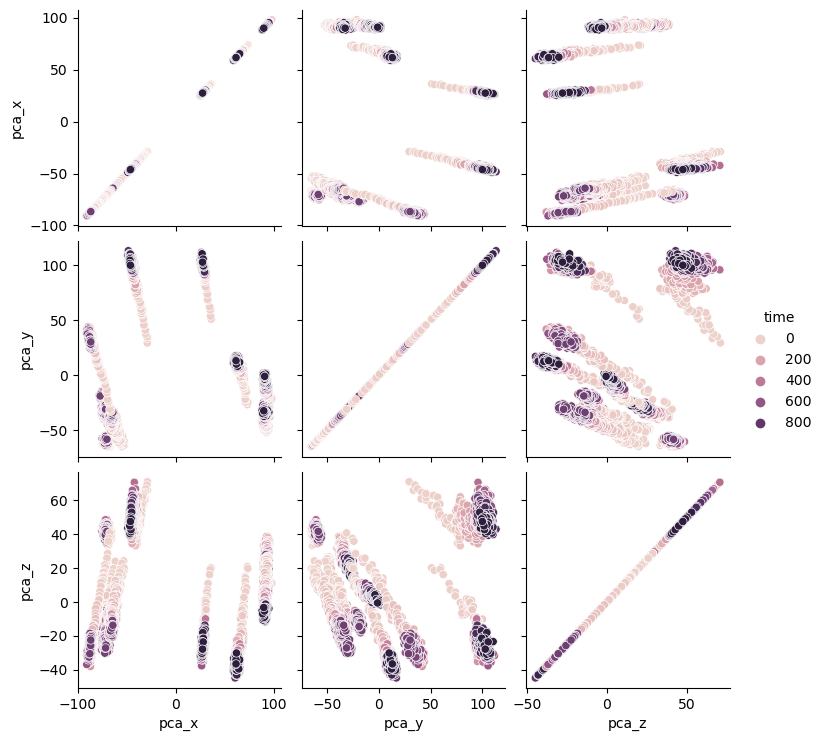

In [32]:
g1 = sns.pairplot(md_pca[['pca_x', 'pca_y', 'pca_z', 'time']], hue='time', diag_kind=None)